In [14]:
#imports
from shared_tools.make_datasets import x_train, y_train
import pygraphviz as pgv
from matplotlib import pyplot as plt
from typing import Iterable
import pickle, os, numpy as np
from PIL import Image
from deap import gp
from functools import partial
from run_gp import get_pset

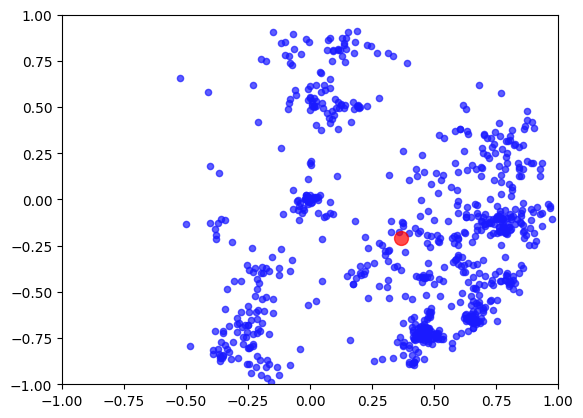

In [15]:
aro, val = sum(a for a, _ in y_train) / len(y_train), sum(v for _, v in y_train) / len(y_train)

def show(a_v_pairs: list[tuple[float, float]]) -> None:
    plt.scatter([a for a, _ in a_v_pairs], [v for _, v in a_v_pairs],  s=20, color=(0.1, 0.1, 1, 0.7))
    plt.scatter([aro], [val], s=100, color=(1, 0, 0, 0.7))
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.show()
show(y_train)

def show_img(img, title):
    plt.imshow(img, cmap="binary")
    plt.colorbar()
    plt.title(title)
    plt.show()

In [16]:
def models(dir_path: str, prefix='') -> list[gp.PrimitiveTree]:
    path = f"{dir_path}/data"
    models= [pickle.load(open(f"{path}/{file}", 'rb')) for file in os.listdir(path) if f'{prefix}best' in file]
    return models

In [17]:
model = models('simple_pred')[0]
compile = partial(gp.compile, pset=get_pset('simple_pred'))
print(compile(model[0].format(2,3))(None))

(2, 3)


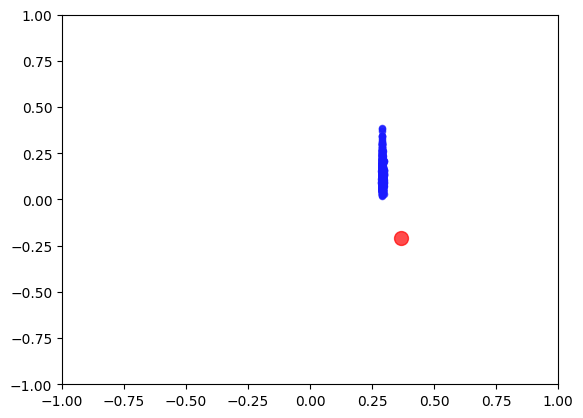

In [18]:
compile = partial(gp.compile, pset=get_pset('simple_pred'))
for model in models('simple_pred')[:2]:
    
    #print(model[0].arity)
    nodes, edges, labels = gp.graph(model)

    predictor = compile(model)
    predictions = [predictor(img) for img in x_train]
    show(predictions)


In [19]:
compile = partial(gp.compile, pset=get_pset('MLGP'))
for arousal_pred, val_pred in list(zip(models('MLGP', prefix='a'), models('MLGP', prefix='v')))[:2]:
    aro_predictions = [compile(arousal_pred)(img) for img in x_train]
    val_predictions = [compile(val_pred)(img) for img in x_train]
    show(list(zip(aro_predictions, val_predictions)))

In [20]:
def rect_region(img_region, x: int, y: int, width: int, height: int):
    width, height = img_region.shape
    x_end = min(width, x + width)
    y_end = min(height, y + height)
    return img_region[x:x_end, y:y_end]

In [21]:
from dataclasses import dataclass
from typing import Any, Callable, Generic, TypeVar

# Define a type variable
T = TypeVar('T')

class Box(Generic[T]):
    def __init__(self, value: T):
        self.value: T = value
@dataclass
class Tree:
    function: Any
    children: list["Tree"]
    pset: gp.PrimitiveSetTyped
    _result: Any = None
    _node_num: int = None

    def __iter__(self):
        return iter((self.function, self.children))
    
    def __repr__(self):
        return self.function.format(*self.children)
    
    def compile(self) -> Callable:
        return gp.compile(self, pset=self.pset)
    
    def get_graph(self, *args) -> pgv.AGraph:
        self._evaluate_all_nodes(*args)
        graph = pgv.AGraph(strict=False, directed=True)
        if not os.path.isdir('_treedata'):
            os.makedirs('_treedata')
        self._populate_graph(graph)
        graph.layout(prog="dot")
        return graph

    def draw(self, *args):
        display(self.get_graph(*args))

    def _populate_graph(self, graph: pgv.AGraph) -> None:

        if self.function.arity == 0:
            graph.add_node(self.id(), label=self.function.format())
        else:
            graph.add_node(self.id(), label=self.function.name)
        
        self._display_result(graph)

        for child in self.children:
            child._populate_graph(graph)
            graph.add_edge(self.id(), child.id(), dir="back")

    def id(self) -> str:
        return str(id(self))
        
    def _display_result(self, graph):
        if self.function.arity == 0 and "ARG" not in self.function.name:
            return
        if isinstance(self._result, np.ndarray):
            graph.add_node(f"{self.id()}result", image=f'_treedata/{self.id()}.png', label="", imagescale=True, fixedsize=True, shape="plaintext", width=1.5, height=1.5)
        else:
            graph.add_node(f"{self.id()}result", label=f"{self._result}", shape="plaintext")

        graph.add_edge(self.id(), f"{self.id()}result", style="invis", dir="both")
        B=graph.add_subgraph([self.id(),f"{self.id()}result"],name=f"{self.id()}-resultholder")
        B.graph_attr['rank']='same'

    def _evaluate_all_nodes(self, *args):
        self._result = self.compile()(*args)

        if isinstance(self._result, np.ndarray):
            image_path = f'_treedata/{self.id()}.png'
            Image.fromarray(self._result).convert('RGB').save(image_path)

        for child in self.children:
            child._evaluate_all_nodes(*args)

    @staticmethod
    def construct_tree(model: list[gp.PrimitiveTree], pset: gp.PrimitiveSetTyped, index: Box[int]) -> "Tree":
        function = model[index.value]
        index.value += 1
        return Tree(function, [Tree.construct_tree(model, pset, index) for _ in range(function.arity)], pset)

    @staticmethod
    def of(model: list[gp.PrimitiveTree], pset: gp.PrimitiveSetTyped) -> "Tree":
        return Tree.construct_tree(model, pset, Box(0))
        

In [22]:
model = sorted(models('simple_pred'), key=len)[5]
f = Tree.of(model, get_pset('simple_pred'))
assert str(model) == str(f), f"{model} != {f}"

IndexError: list index out of range

In [9]:
for i, model in list(enumerate(models('simple_pred')))[:5]:
    f = Tree.of(model, get_pset('simple_pred'))
    f.get_graph(x_train[0]).draw(f"test{i}-1.png"), f.get_graph(x_train[10]).draw(f"test2-{i}.png")
    #Image.open(f"test2-{i}.png").show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/loaf/Documents/SummerResearch/performant_refactor/_treedata/131936462097536.png'

TypeError: Invalid shape (54756,) for image data

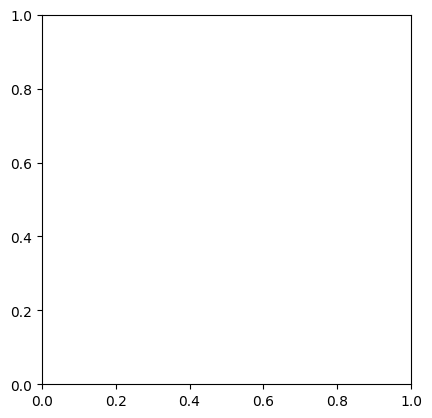

In [29]:
from simple_pred.function_set import hist_equal, lbp, gaussian_1, hog_feature, gaussian_11, gauGM, laplace, sobel_x, sobel_y, gaussian_Laplace1, gaussian_Laplace2, rect_region, square_region, rescale

functions_to_check = [
        (lambda i: i, "Identity"),
        (hist_equal, 'Hist_Eq'), (gaussian_1, 'Gau1'),(gaussian_11, 'Gau11'),
        (gauGM, 'GauXY'), (laplace, 'Lap'), (sobel_x, 'Sobel_X'),
        (sobel_y, 'Sobel_Y'), (gaussian_Laplace1, 'LoG1'),
        (gaussian_Laplace2, 'LoG2'), (lbp, 'LBP'), (hog_feature, 'HOG'), (rescale, 'rescale')
    ]

for func, name in functions_to_check:
    if name != 'HOG':
        continue
    show_img(func(x_train[0]), name)


In [163]:
!rm _treedata/*

rm: cannot remove '_treedata/*': No such file or directory


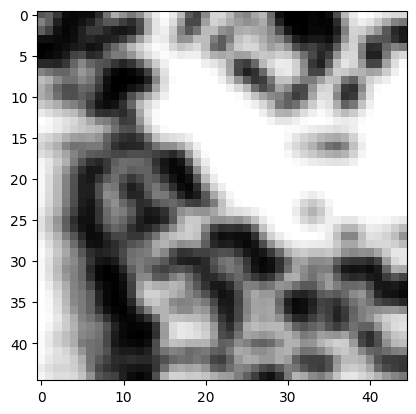

In [167]:
show_img(hist_equal(gaussian_1(gaussian_11(square_region(x_train[0], 85, 29, 45)))), '')

In [ ]:
z